# Image Reshaping
* Experiment with converting an image into separate 1D vectors and then passing thru SegmentNet layers to train / predict

# Initialization

In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timeit
from tqdm import tqdm

In [49]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Image Dataset

## Download MNIST

In [9]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_set = datasets.MNIST('data', train=True, download=False, transform=transform)

In [46]:
len(train_set)

60000

In [11]:
# get 1st image
index = 2
# Get the image and its corresponding label
image, label = train_set[index]

torch.Size([1, 28, 28])


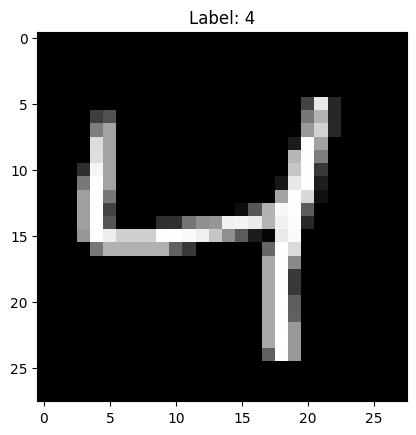

In [12]:
# display MNST image
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

torch.Size([28, 28])


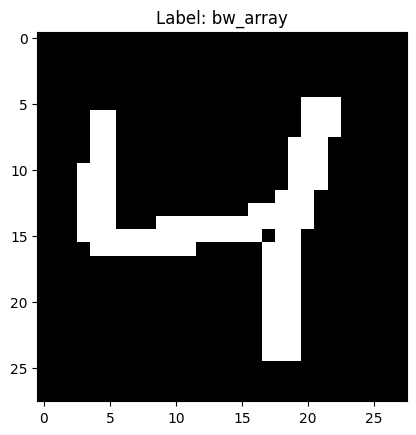

In [13]:
# Let us convert the image to BW image (atleast for this dataset)

def get_bw_array(image):
    test_image = image.squeeze().numpy() #[0:20,:] #or reshape if needed for testing
    limit = test_image.mean()
    bw_array  = torch.tensor(np.where(test_image < limit, 0, 1))
    return bw_array

bw_array = get_bw_array(image)
#display bw_array
print(bw_array.shape)
plt.imshow(bw_array, cmap='gray')
plt.title(f"Label: bw_array")
plt.show()

## Image flattening experiments

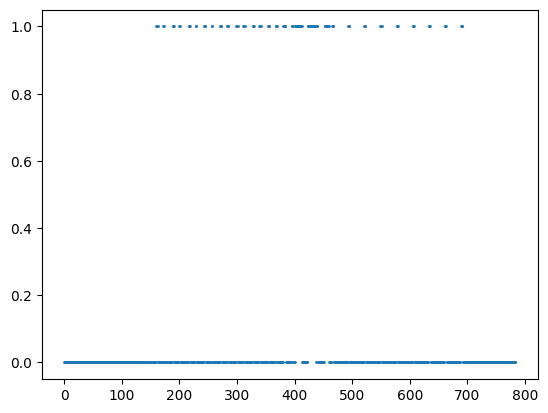

In [14]:
# To flatten 2D image to 1D by row
row_wise = torch.flatten(bw_array)
x = torch.arange(row_wise.shape[0])
y = row_wise.data
plt.scatter(x, y, s=1) #not very interesting

(28, 1)


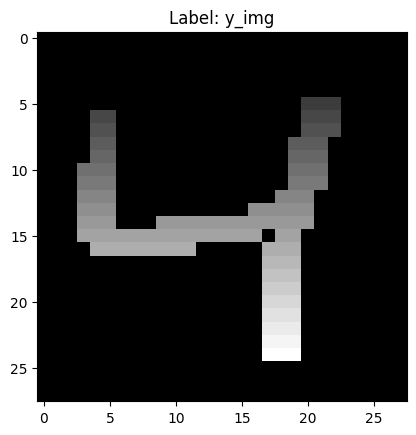

In [15]:
# the above image is not interesting as it only has 0 or 1 values
# let us replace 1 values with column height
# we start arange from 1 as we want to differentiate between no value and 1st row value
y_val = np.arange(1,bw_array.shape[0]+1)
y_val = y_val.reshape(y_val.shape[0],1)
print(y_val.shape)
y_img = bw_array*y_val

#Verify that y_val is same for every horizontal line
plt.imshow(y_img, cmap='gray')
plt.title(f"Label: y_img")
plt.show()

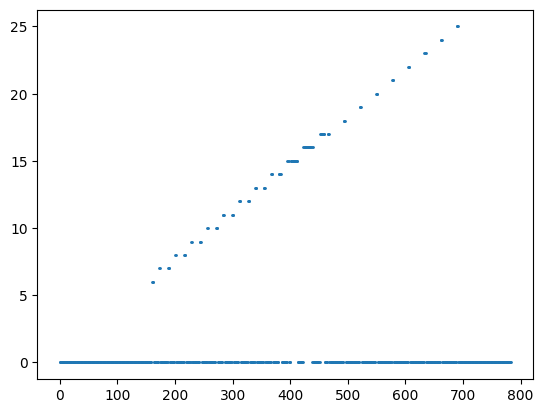

In [16]:
row_wise = y_img.flatten()
x = torch.arange(row_wise.shape[0])
y = row_wise.data #position on y * intensity (1)
plt.scatter(x, y, s=1) # Looks trainable 

In [17]:
for i in range(x.data.shape[0]):
    print(x.data[i].item(),y.data[i].item())


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 6
161 6
162 6
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 7
173 7
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


(28,)


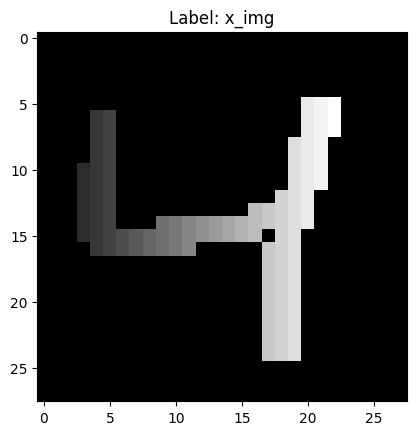

In [18]:
# Let us try column wise
# let us replace 1 values with row width
# we start arange from 1 as we want to differentiate between no value and 1st column value
x_val = np.arange(1,bw_array.shape[0]+1)
print(x_val.shape)
x_img = bw_array*x_val

#Verify that y_val is same for every horizontal line
plt.imshow(x_img, cmap='gray')
plt.title(f"Label: x_img")
plt.show()

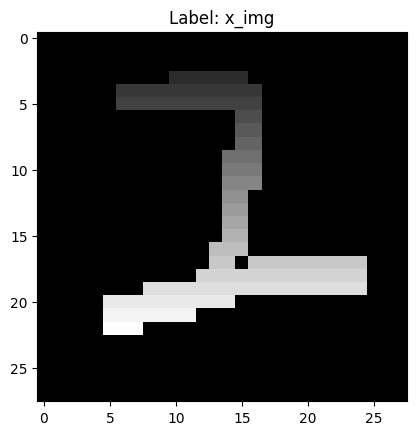

In [19]:
# To Column-wise Flatten, we first rotate the image 90 degrees
plt.imshow(x_img.permute(1,0), cmap='gray')
plt.title(f"Label: x_img")
plt.show()

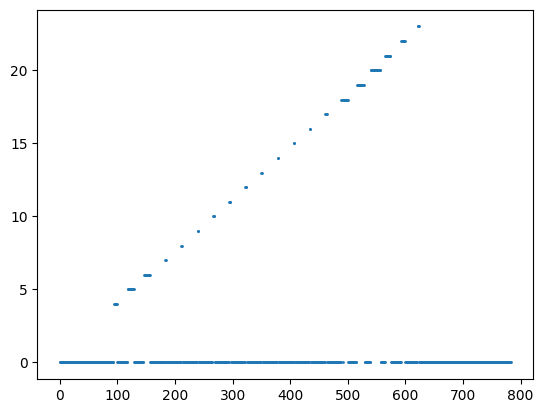

In [20]:
# now we can flatten column-wise
col_wise = x_img.permute(1,0).flatten()
x = torch.arange(col_wise.shape[0])
y = col_wise.data #position on y * intensity (1)
plt.scatter(x, y, s=1) # Looks trainable and different than row_wise

## Image Flattening Function

In [106]:
# Create function that returns x,y for an image
def flatten_image(image, row_wise=True):
    if row_wise:
        columns = np.arange(1,image.shape[0]+1)
        # reshape the image only for row_wise so product works
        columns = columns.reshape(y_val.shape[0],1)
        # Create an image that contains y_position info along with color depth
        y_img = image #*columns
        #flatten the image to get x, y
        row_wise_data = y_img.flatten()
        x = torch.arange(row_wise_data.shape[0]) # row wise sequence of data
        x = x/row_wise_data.shape[0] # Normalize
        y = row_wise_data # row location from 1:N multipled by color depth. 
        # NOTE: data is not normalized. 
        return x.to(torch.float16), y.to(torch.float16), y_img
    else:
        rows = np.arange(1,image.shape[1]+1)
        x_img = image #*rows #No need to reshape for col_wise
        # We need to rotate the image by 90 degrees to flatten it by column
        col_wise_data = x_img.permute(1,0).flatten()
        x = torch.arange(col_wise_data.shape[0])
        x = x/col_wise_data.shape[0] # Normalize
        y = col_wise_data
        return x.to(torch.float), y.to(torch.float), x_img
            

### Test function

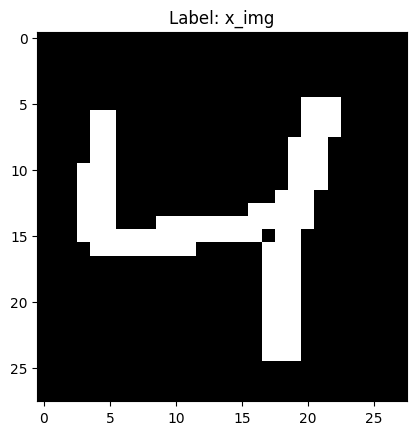

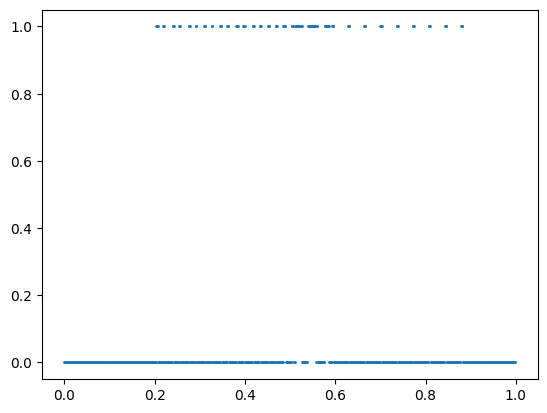

In [107]:
# flatten by row
image = bw_array
x, y, newimg = flatten_image(image.squeeze())
plt.imshow(newimg, cmap='gray')
plt.title(f"Label: x_img")
plt.show()
plt.scatter(x, y, s=1)

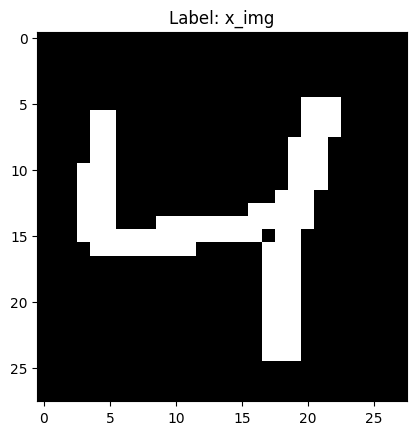

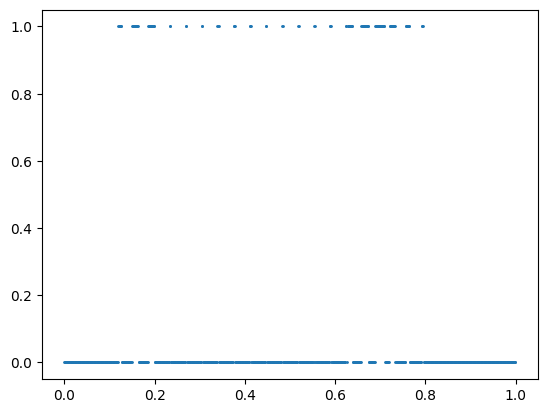

In [108]:
# flatten by col
x, y, newimg = flatten_image(image.squeeze(),row_wise=False)
plt.imshow(newimg, cmap='gray')
plt.title(f"Label: x_img")
plt.show()
plt.scatter(x, y, s=1)

# MNIST test and Test dataset

In [179]:
#example of column wise flatten
x = torch.tensor([[[1, 2, 3], [4, 5, 6]]])
print(x.shape)
print(x.permute(0,2,1).flatten()) 

torch.Size([1, 2, 3])
tensor([1, 4, 2, 5, 3, 6])


In [47]:
from torchvision import datasets, transforms

flatten_by_row_transform = transforms.Lambda(lambda x: x.flatten())
flatten_by_col_transform = transforms.Lambda(lambda x: x.permute(0,2,1).flatten())

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5]),
    flatten_by_row_transform
])

train_set = datasets.MNIST('data', train=True, download=False, transform=transform)
test_set = datasets.MNIST('data', train=False, download=False, transform=transform)
print(len(train_set), len(test_set))


60000 10000


In [4]:
image, label = train_set[0]
print(image.shape, label)

torch.Size([784]) 5


# Train a segmentNet for row_wise and column_wise data
* experiment with two separate nets and one combined net

# TODO
* Experiment where all x_in is simply 1/num_of_labels or  hard code it to 1
* Segment outputs multiple y (size of ytest.shape[0])
* start with 1 segment and see if a single x (0.1) and single segment per x,y combination can learn an image
* then add second image with same label but one image will have x=0.5 another will have x=1

## Not working as x has only one value. we need more than one distinct x for the model to learn
* Todo: Add multiple images with different x

## Model Init

In [5]:
from segment import Segment

In [56]:
in_features=784
out_features=10 #classes
segments=10
model = Segment(in_features, out_features, segments).to(device)

criterion = nn.CrossEntropyLoss()

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

# create dataset that can be used in a dataloader 
batch_size=64
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

#Initialize model parameters - extremely important.
# as we have normalized valies between -1., 1. we can create a min, max array
x_min = torch.tensor([-1.]*in_features)
x_max = torch.tensor([1.]*in_features)
model.custom_init(x_min, x_max)

In [59]:
# Train
num_epochs = 10
initalized = False
losses = np.array([])
start = timeit.default_timer()
for epoch in tqdm(range(1, num_epochs+1), position=0, leave=True):
    model.train()
    train_loss = 0
    train_labels = []
    train_preds = []
    for batch_idx, data in enumerate(tqdm(trainloader, position=0, leave=True)):
        # Forward pass
        [X, Y] = data
        ypred = model(X.to(device))
        y_pred_label = torch.argmax(ypred, dim=1)
        train_labels.extend(Y.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        # Calculate the loss
        loss = criterion(ypred, Y.to(device))
        if math.isnan(loss):
            print("Loss is nan")
            break

        train_loss += loss.item()
        
        # Backward and optimize
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if math.isnan(loss):
        print("Loss is nan")
        break

    train_loss = train_loss/(batch_idx+1)
    losses = np.append(losses, train_loss)
    print("-"*30)
    print(f"Train Accuracy EPOCH {epoch}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    print("-"*30)

    #Run evaluation
    model.eval()
    test_loss = 0
    test_labels = []
    test_preds = []
    for batch_idx, data in enumerate(tqdm(testloader, position=0, leave=True)):
        # Forward pass
        [X, Y] = data
        ypred = model(X.to(device))
        y_pred_label = torch.argmax(ypred, dim=1)
        test_labels.extend(Y.cpu().detach())
        test_preds.extend(y_pred_label.cpu().detach())
        # Calculate the loss
        loss = criterion(ypred, Y.to(device))
        if math.isnan(loss):
            print("Loss is nan")
            break

        test_loss += loss.item()
   
    if math.isnan(loss):
        print("Loss is nan")
        break

    test_loss = test_loss/(batch_idx+1)
    print("-"*30)
    print(f"Test Accuracy EPOCH {epoch}: {sum(1 for x,y in zip(test_preds, test_labels) if x == y) / len(test_labels):.4f}")
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, test_loss))
    print("-"*30)


stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


100%|██████████| 938/938 [00:30<00:00, 30.87it/s]


------------------------------
Train Accuracy EPOCH 1: 0.8036
====> Epoch: 1 Average loss: 0.9967
------------------------------


 10%|█         | 1/10 [00:33<05:00, 33.43s/it]

------------------------------
Test Accuracy EPOCH 1: 0.8831
====> Epoch: 1 Average loss: 0.5574
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.99it/s]


------------------------------
Train Accuracy EPOCH 2: 0.8875
====> Epoch: 2 Average loss: 0.4762
------------------------------


 20%|██        | 2/10 [01:05<04:21, 32.66s/it]

------------------------------
Test Accuracy EPOCH 2: 0.9025
====> Epoch: 2 Average loss: 0.4017
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.86it/s]


------------------------------
Train Accuracy EPOCH 3: 0.9032
====> Epoch: 3 Average loss: 0.3765
------------------------------


 30%|███       | 3/10 [01:37<03:47, 32.49s/it]

------------------------------
Test Accuracy EPOCH 3: 0.9091
====> Epoch: 3 Average loss: 0.3442
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.29it/s]


------------------------------
Train Accuracy EPOCH 4: 0.9134
====> Epoch: 4 Average loss: 0.3282
------------------------------


 40%|████      | 4/10 [02:10<03:15, 32.60s/it]

------------------------------
Test Accuracy EPOCH 4: 0.9183
====> Epoch: 4 Average loss: 0.3115
------------------------------


100%|██████████| 938/938 [00:30<00:00, 31.23it/s]


------------------------------
Train Accuracy EPOCH 5: 0.9207
====> Epoch: 5 Average loss: 0.2978
------------------------------


 50%|█████     | 5/10 [02:43<02:43, 32.68s/it]

------------------------------
Test Accuracy EPOCH 5: 0.9220
====> Epoch: 5 Average loss: 0.2930
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.56it/s]


------------------------------
Train Accuracy EPOCH 6: 0.9257
====> Epoch: 6 Average loss: 0.2761
------------------------------


 60%|██████    | 6/10 [03:15<02:10, 32.62s/it]

------------------------------
Test Accuracy EPOCH 6: 0.9233
====> Epoch: 6 Average loss: 0.2808
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.60it/s]


------------------------------
Train Accuracy EPOCH 7: 0.9310
====> Epoch: 7 Average loss: 0.2590
------------------------------


 70%|███████   | 7/10 [03:48<01:37, 32.59s/it]

------------------------------
Test Accuracy EPOCH 7: 0.9261
====> Epoch: 7 Average loss: 0.2708
------------------------------


100%|██████████| 938/938 [00:30<00:00, 30.61it/s]


------------------------------
Train Accuracy EPOCH 8: 0.9337
====> Epoch: 8 Average loss: 0.2454
------------------------------


 80%|████████  | 8/10 [04:21<01:05, 32.87s/it]

------------------------------
Test Accuracy EPOCH 8: 0.9273
====> Epoch: 8 Average loss: 0.2645
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.59it/s]


------------------------------
Train Accuracy EPOCH 9: 0.9373
====> Epoch: 9 Average loss: 0.2341
------------------------------


 90%|█████████ | 9/10 [04:54<00:32, 32.77s/it]

------------------------------
Test Accuracy EPOCH 9: 0.9289
====> Epoch: 9 Average loss: 0.2582
------------------------------


100%|██████████| 938/938 [00:29<00:00, 31.29it/s]


------------------------------
Train Accuracy EPOCH 10: 0.9396
====> Epoch: 10 Average loss: 0.2244
------------------------------


100%|██████████| 10/10 [05:27<00:00, 32.73s/it]

------------------------------
Test Accuracy EPOCH 10: 0.9311
====> Epoch: 10 Average loss: 0.2543
------------------------------
Training Time: 327.28s


In [52]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_Segment_test_graph")

'model_Segment_test_graph.pdf'

In [96]:
x_in.min(), x_in.max()

(tensor(0.), tensor(0.0618))

In [97]:
ytest.min(), ytest.max()

(tensor(0.), tensor(0.1700))